# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.cluster import KMeans


# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
azdias.shape

(891221, 85)

In [6]:
azdias.dtypes.value_counts()

float64    49
int64      32
object      4
dtype: int64

## **Colunms with "object" values** 

In [7]:
azdias.dtypes[azdias.dtypes=="object"]

OST_WEST_KZ        object
CAMEO_DEUG_2015    object
CAMEO_DEU_2015     object
CAMEO_INTL_2015    object
dtype: object

In [8]:
# Apesar de possuir texto. Não ha valores que nos interessam agora.
azdias["OST_WEST_KZ"].value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [9]:
# Esta Coluna possui X
azdias["CAMEO_DEUG_2015"].value_counts()["X"]

373

In [10]:
# Esta Coluna possui XX
azdias["CAMEO_DEU_2015"].value_counts()["XX"]

373

In [11]:
# Esta Coluna possui XX
azdias["CAMEO_INTL_2015"].value_counts()["XX"]

373

## **About feat_info**

In [12]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [13]:
feat_info.dtypes

attribute             object
information_level     object
type                  object
missing_or_unknown    object
dtype: object

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [14]:
# 1 Remover caracteres e 2 separar cada numero separado por virgula(",").
feat_info["missing_or_unknown"]  = feat_info["missing_or_unknown"].str.strip("[]").str.split(",")

In [15]:
# Calcula o nuémero de miss_values
total_miss_values = azdias.isnull().sum().sort_values(ascending=False).sum()
print(f"Total missing values = {total_miss_values}")

Total missing values = 4896838


In [16]:
# Identifica se há valores com X ou XX
def find_x_values():
    for name, y in zip(feat_info["attribute"],feat_info["missing_or_unknown"]):
        try:
            if "X" in y:
                for x in y:
                    if x == "X" or x == "XX" or x == "":
                        val=str(x)
                        print(f"Was found {azdias[name].value_counts()[val]} {val} in {name}")
                    

            elif "XX" in y:
                for x in y:
                    #print(x)
                    if x == "X" or x == "XX" or x == "":
                        val=str(x)
                        print(f"Was found {azdias[name].value_counts()[val]} {val} in {name}")
        except:
            print(f"{val} was not found in {name}")

In [17]:
# Columns with X or XX values
find_x_values()

Was found 373 X in CAMEO_DEUG_2015
Was found 373 XX in CAMEO_DEU_2015
Was found 373 XX in CAMEO_INTL_2015


In [18]:
# Identify missing or unknown data values and convert them to NaNs.
for x, y in zip(feat_info["attribute"],feat_info["missing_or_unknown"]):
    for num in y:
        if num == "X" or num == "XX" or num == "":
            azdias[x].replace(num, np.nan, inplace=True) 
        else:
            azdias.loc[azdias[x]==int(num),x] = np.nan
            
total_miss_values = azdias.isnull().sum().sort_values(ascending=False).sum()
print(f"total missing values after converting them into NaNs  = {total_miss_values}")

total missing values after converting them into NaNs  = 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

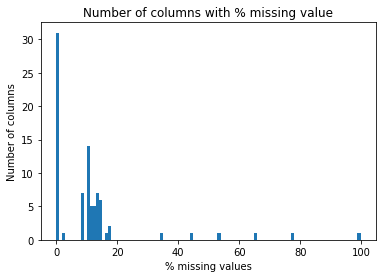

In [19]:
# Number of columns with % missing values. Ex: 5 Columns with =~10% mising values
df_null = (azdias.isnull().sum()/len(azdias))*100
plt.hist(df_null, bins=100)
plt.title("Number of columns with % missing value")
plt.xlabel("% missing values")
plt.ylabel("Number of columns")
plt.show()

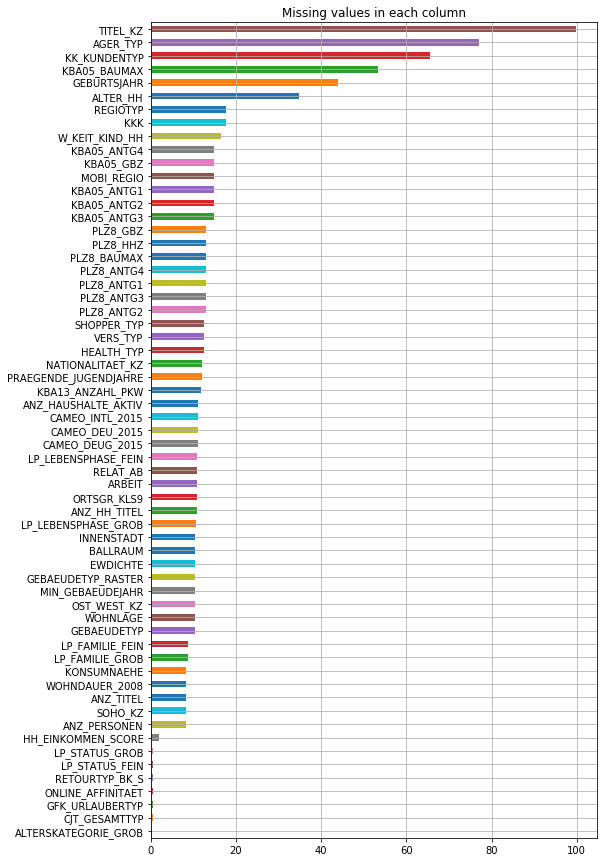

In [20]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
my_plot = df_null[df_null>0]
#my_plot = azdias.isnull().sum()[azdias.isnull().sum()>0]/len(azdias)

my_plot.sort_values().plot(kind="barh", figsize=(8,15), grid="on", title="Missing values in each column")

In [21]:
# Investigate patterns in the amount of missing data in each column.
# The most columns have up to 20% missing values
df_null.describe()

count    85.000000
mean     11.054139
std      16.449815
min       0.000000
25%       0.000000
50%      10.451729
75%      13.073637
max      99.757636
dtype: float64

In [22]:
# outlier columns == more than 20% missing value
df_null[df_null>20].sort_values(ascending=False)

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64

In [23]:
# List outlier for drop
drop_columns = df_null[df_null>20].axes[0].tolist()
drop_columns

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [24]:
# Shape before drop
azdias.shape

(891221, 85)

In [25]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(drop_columns, axis=1, inplace=True)

# Shape after drop
azdias.shape

(891221, 79)

In [26]:
azdias_describe = azdias.isnull().sum()/(len(azdias))*100

In [27]:
azdias_describe.describe()

count    79.000000
mean      7.151764
std       6.087588
min       0.000000
25%       0.000000
50%      10.451729
75%      12.145080
max      17.735668
dtype: float64

#### Discussion 1.1.2: Assess Missing Data in Each Column

- Now we have 79 instead of the initial 85 columns.
- Columns with more than 20% missing values were considered outliers
- The columns AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX were removed because they were considered outlier columns.
- Most columns, 75%, have up to 13% missing values
- 25% of columns do not have missing values

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

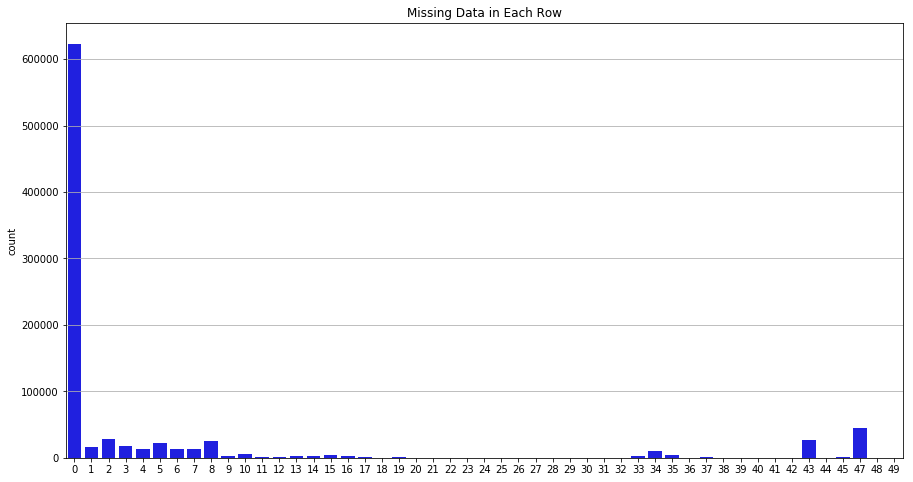

In [28]:
# How much data is missing in each row of the dataset?
my_plot = azdias.isnull().sum(axis = 1).values
plt.figure(figsize=(15,8))
plt.grid(b=True)
plt.title("Missing Data in Each Row")
sns.countplot(my_plot, color='blue')

#my_plot.sort_values().plot(kind="barh", figsize=(8,15), grid="on", title="Missing values in each column")

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# the answer to life, universe and everything... It's 42
azdias_null_row = azdias.isnull().sum(axis = 1).values


subset1 = azdias.loc[azdias_null_row<=42]
subset2 = azdias.loc[azdias_null_row>42] 


In [30]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
subset1_null_row = subset1.isnull().sum(axis=0).values
subset2_null_row = subset2.isnull().sum(axis=0).values

In [31]:
subset1_plot=subset1[subset1.columns[:6]]
subset2_plot=subset2[subset2.columns[:6]]

print("Subset1 has {:.2f} % missing values".format((1-subset1_plot.shape[0]/azdias.shape[0])*100))
print("Subset2 has {:.2f} % missing values".format((1-subset2_plot.shape[0]/azdias.shape[0])*100))

# https://stackoverflow.com/questions/11285613/selecting-multiple-columns-in-a-pandas-dataframe

Subset1 has 8.26 % missing values
Subset2 has 91.74 % missing values


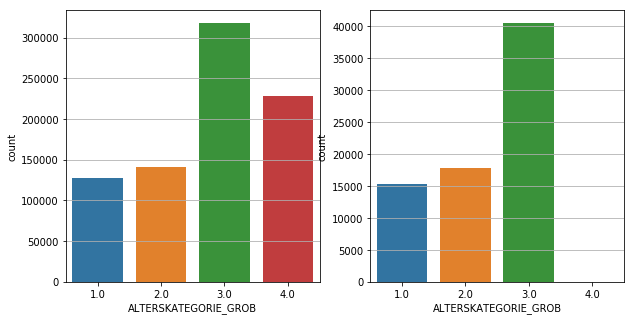

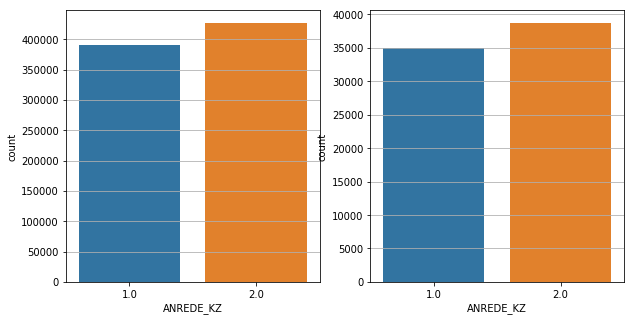

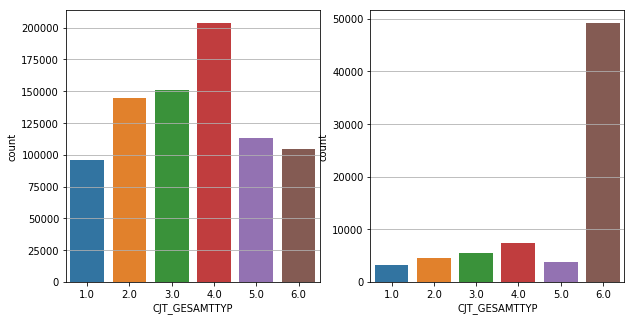

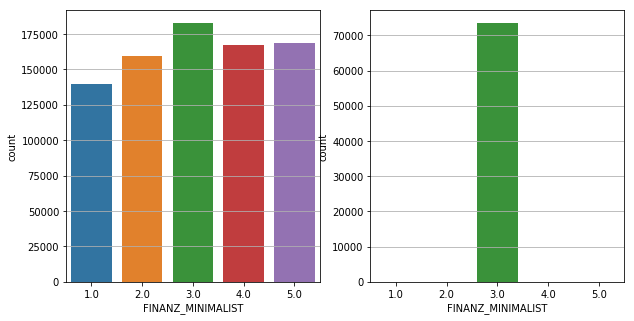

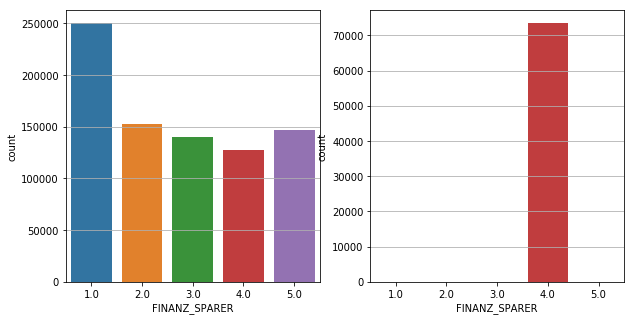

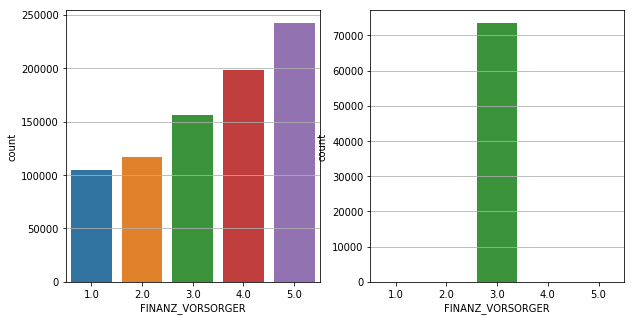

In [32]:
for x in subset1_plot:  
    plt.figure(figsize=(10,5))
    #plt.grid(b=True)
    #plt.title("Missing Data in Each Row")

    plt.subplot(121)
    my_plot_1 = subset1_plot[x]
    plt.grid(b=True)
    sns.countplot(my_plot_1)
    
    plt.subplot(122)
    my_plot_2 = subset2_plot[x]
    plt.grid(b=True)
    sns.countplot(my_plot_2)

#### Discussion 1.1.3: Assess Missing Data in Each Row

- The Subset1 has 8.26 % missing values on the other hand, the Subset2 has 91.74 % missing values.

- The subset1 are  qualitatively different from subset2

- Some columns display similar values, such as "ALTERSKATEGORIE_GROB" and "ANREDE_KZ". But subset1 is still more relevant.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
# How many features are there of each data type?
# With columns (rows) in drop_columns
feat_info["type"].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [34]:
# Total
feat_info["type"].value_counts().sum()

85

In [35]:
# Without columns (rows) in drop_columns
# Delete the rows with label in drop_columns
# For label-based deletion, set the index first on the dataframe:
feat_drop = feat_info.set_index("attribute")
feat_drop = feat_drop.drop(drop_columns, axis=0) # Delete all rows with label in drop_columns
feat_drop["type"].value_counts()

# https://www.shanelynn.ie/using-pandas-dataframe-creating-editing-viewing-data-in-python/

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [36]:
# Total
feat_drop["type"].value_counts().sum()

79

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [37]:
azdias = subset1

In [38]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
len(feat_drop[feat_drop["type"]=="categorical"])

18

In [39]:
feat_drop.reset_index(inplace=True)
#https://appdividend.com/2019/01/26/pandas-set-index-example-python-set_index-tutorial/

In [40]:
attrib_bin = feat_drop[feat_drop["type"]=="categorical"]["attribute"]

In [41]:
for x in attrib_bin:
    print(x, azdias[x].unique())

ANREDE_KZ [ 2.  1.]
CJT_GESAMTTYP [  5.   3.   2.   4.   1.   6.  nan]
FINANZTYP [ 1.  6.  5.  2.  4.  3.]
GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   2.   7.   6.  nan]
GREEN_AVANTGARDE [0 1]
LP_FAMILIE_FEIN [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB [  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ [  1.   3.   2.  nan]
SHOPPER_TYP [  3.   2.   1.   0.  nan]
SOHO_KZ [ 1.  0.]
VERS_TYP [  2.   1.  nan]
ZABEOTYP [ 5.  3.  4.  1.  6.  2.]
GEBAEUDETYP [  8.   1.   3.   2.  nan   6.   4.   5.]
OST_WEST_KZ ['W' nan 'O']
CAMEO_DEUG_2015 ['8' '4' '2' '6' '1' '9' '5' '7' nan '3']
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


In [42]:
binary=[]
multlevel=[]
for x in attrib_bin:
    if (len(azdias[x].unique())<=3):
        binary.append(x)
    else:
        multlevel.append(x)

print(f"Binary features = {len(binary)} {binary}\n")
print(f"multi-level features = {len(multlevel)} {multlevel}")

Binary features = 5 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

multi-level features = 13 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [43]:
azdias["OST_WEST_KZ"].value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [44]:
new_value = azdias["OST_WEST_KZ"]
new_value.replace('W',1, inplace=True)
new_value.replace('O',0, inplace=True)
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

In [45]:
azdias["OST_WEST_KZ"].value_counts()

1.0    629528
0.0    168545
Name: OST_WEST_KZ, dtype: int64

In [46]:
# Re-encode categorical variable(s) to be kept in the analysis.
len(azdias.columns)

79

In [47]:
azdias.drop(multlevel, axis=1, inplace=True)

In [48]:
len(azdias.columns)

66

#### Discussion 1.2.1: Re-Encode Categorical Features

- For lack of time and to keep things simple, I dropped the multi-level categories. Maybe with more time I would keep them.
- I recoded the values of "OST_WEST_KZ" {W = 1 and O = 0}.
- The other binary categories were maintained

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [49]:
#feat_drop
#feat_drop.set_index("attribute")

In [50]:
mixed_feature = feat_drop.set_index("attribute")
#mixed_feature = feat_drop[feat_drop["type"]=="mixed"].index
mixed_feature = mixed_feature[mixed_feature["type"]=="mixed"].index
mixed_feature

Index(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE',
       'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'],
      dtype='object', name='attribute')

In [51]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias["PRAEGENDE_JUGENDJAHRE"].value_counts()

14.0    188671
8.0     145961
5.0      86405
10.0     85808
3.0      55190
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21281
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [52]:
def apply_decade(x):
    if x in (1,2):
        return 1
    elif x in (3,4):
        return 2
    elif x in (5,6,7):
        return 3
    elif x in (8,9):
        return 4
    elif x in (10,11,12,13):
        return 5
    elif x in (14,15):
        return 6
# http://jonathansoma.com/lede/foundations/classes/pandas%20columns%20and%20functions/apply-a-function-to-every-row-in-a-pandas-dataframe/

In [53]:
azdias["PRAEGENDE_JUGENDJAHRE_DECADE"] = azdias["PRAEGENDE_JUGENDJAHRE"].apply(apply_decade)
azdias["PRAEGENDE_JUGENDJAHRE_DECADE"].head()

1    6.0
2    6.0
3    4.0
4    4.0
5    2.0
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: float64

In [54]:
def apply_movement(x):
    if x in (1,3,5,8,10,12,14):
        return 0
    elif x in (2,4,6,7,9,11,13,15):
        return 1

In [55]:
azdias["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = azdias["PRAEGENDE_JUGENDJAHRE"].apply(apply_movement)
azdias["PRAEGENDE_JUGENDJAHRE_MOVEMENT"].head()

1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: float64

In [56]:
len(azdias.columns)

68

In [57]:
azdias.drop("PRAEGENDE_JUGENDJAHRE", axis=1, inplace=True)

In [58]:
len(azdias.columns)

67

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [59]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias["CAMEO_INTL_2015"].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [60]:
# wealth

In [61]:
def apply_wealth(x):
    try:
        if int(x) in (11,12,13,14,15):
            return 1
        elif int(x) in (21,22,23,24,25):
            return 2
        elif int(x) in (31,32,33,34,35):
            return 3
        elif int(x) in (41,42,43,44,45):
            return 4
        elif int(x) in (51,52,53,54,55):
            return 5
    except:
        return np.nan

In [62]:
azdias["CAMEO_INTL_2015_WEALTH"] = azdias["CAMEO_INTL_2015"].apply(apply_wealth)
azdias["CAMEO_INTL_2015_WEALTH"].head()

1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: CAMEO_INTL_2015_WEALTH, dtype: float64

In [63]:
azdias["CAMEO_INTL_2015_WEALTH"].value_counts()

5.0    223582
2.0    190691
4.0    189960
1.0    119443
3.0     68193
Name: CAMEO_INTL_2015_WEALTH, dtype: int64

In [64]:
# life stage

In [65]:
def apply_lifestage(x):
    try:
        if int(x) in (11,21,31,41,51):
            return 1
        elif int(x) in (12,22,32,42,52):
            return 2
        elif int(x) in (13,23,33,43,53):
            return 3
        elif int(x) in (14,24,34,44,54):
            return 4
        elif int(x) in (15,25,35,45,55):
            return 5
    except:
        return np.nan

In [66]:
azdias["CAMEO_INTL_2015_LIFESTAGE"] = azdias["CAMEO_INTL_2015"].apply(apply_lifestage)
azdias["CAMEO_INTL_2015_LIFESTAGE"].head()

1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: float64

In [67]:
azdias["CAMEO_INTL_2015_LIFESTAGE"].value_counts()

1.0    245054
4.0    232777
3.0    119693
5.0    117045
2.0     77300
Name: CAMEO_INTL_2015_LIFESTAGE, dtype: int64

In [68]:
len(azdias.columns)

69

In [69]:
azdias.drop("CAMEO_INTL_2015", axis=1, inplace=True)

In [70]:
len(azdias.columns)

68

In [71]:
azdias.shape

(817622, 68)

In [72]:
mixed_feature = mixed_feature.drop(["CAMEO_INTL_2015", "PRAEGENDE_JUGENDJAHRE"])

In [73]:
# Drop the mixed columns
mixed_feature

Index(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE',
       'PLZ8_BAUMAX'],
      dtype='object', name='attribute')

In [74]:
azdias.shape

(817622, 68)

#### Discussion 1.2.2: Engineer Mixed-Type Features

- The PRAEGENDE_JUGENDJAHRE was replaced for PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT.
- The CAMEO_INTL_2015 was replaced for CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFESTAGE
- PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 was replaced and after dropped
- LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, WOHNLAGE and PLZ8_BAUMAX was Dropped

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [75]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias.drop(mixed_feature,axis=1, inplace=True )
azdias.shape

(817622, 64)

In [76]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEI

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [77]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for x, y in zip(feat_info["attribute"],feat_info["missing_or_unknown"]):
        for num in y:
            if num == "X" or num == "XX" or num == "":
                df[x].replace(num, np.nan) 
            else:
                df.loc[df[x]==int(num),x] = np.nan
    
    # remove selected columns and rows, ...
    
    ## Step 1.1.2: Assess Missing Data in Each Column
    #df_null = (df.isnull().sum()/len(df))*100
    #drop_columns = df_null[df_null>20].axes[0].tolist()
    #df.drop(drop_columns, axis=1, inplace=True)
    df = df.drop(drop_columns, axis=1)
    
    ## Step 1.1.3: Assess Missing Data in Each Row
    df_null_row = df.isnull().sum(axis = 1).values
    df_sub1 = df.loc[df_null_row<=42]

    
    # select, re-encode, and engineer column values.
    
    ## Step 1.2: Select and Re-Encode Features
    feat_drop = feat_info.set_index("attribute")
    feat_drop = feat_drop.drop(drop_columns, axis=0)

    ## Step 1.2.1: Re-Encode Categorical Features
    feat_drop = feat_drop.reset_index()
    
    attrib_bin = feat_drop[feat_drop["type"]=="categorical"]["attribute"]

    binary=[]
    multlevel=[]
    for x in attrib_bin:
        if (len(df_sub1[x].unique())<=3):
            binary.append(x)
        else:
            multlevel.append(x)

    #new_value = df_sub1["OST_WEST_KZ"]
    df_sub1 = df_sub1.replace('W',1)
    df_sub1 = df_sub1.replace('O',0)

    #####df_sub1.drop(multlevel, axis=1, inplace=True) 
    
    ## Step 1.2.2: Engineer Mixed-Type Features
    mixed_feature = feat_drop.set_index("attribute")
    mixed_feature = mixed_feature[mixed_feature["type"]=="mixed"].index
    
    try:
        df_sub1["PRAEGENDE_JUGENDJAHRE_DECADE"] = df_sub1["PRAEGENDE_JUGENDJAHRE"].apply(apply_decade)
        df_sub1["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = df_sub1["PRAEGENDE_JUGENDJAHRE"].apply(apply_movement)

        df_sub1 = df_sub1.drop("PRAEGENDE_JUGENDJAHRE", axis=1)
    except:
        pass
    
    ### 4.3. CAMEO_INTL_2015
    try:
        df_sub1["CAMEO_INTL_2015_WEALTH"] = df_sub1["CAMEO_INTL_2015"].apply(apply_wealth)
        df_sub1["CAMEO_INTL_2015_LIFESTAGE"] = df_sub1["CAMEO_INTL_2015"].apply(apply_lifestage)
        df_sub1 = df_sub1.drop("CAMEO_INTL_2015", axis=1)

        mixed_feature = mixed_feature.drop(["CAMEO_INTL_2015", "PRAEGENDE_JUGENDJAHRE"])
    except:
        pass
    
    
    df_sub1.drop(multlevel, axis=1, inplace=True) 
    
    df_sub1 = df_sub1.drop(mixed_feature,axis=1)
    
    # Return the cleaned dataframe.
    return df_sub1

# https://stackoverflow.com/questions/32752299/pandas-warning-while-trying-to-delete-column

In [78]:
azdias_new = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")
df_clean_def = clean_data(azdias_new)

In [79]:
df_clean_def.shape

(817622, 64)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [80]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
df_no_missing = azdias.dropna()
df_no_missing_null = df_no_missing.isnull().sum()

In [81]:
df_no_missing_null[df_no_missing_null>0]

Series([], dtype: int64)

In [82]:
df_no_missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,0.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,1.0,2.0,4.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,0.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,0.0,5.0,4.0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0,2.0,...,0.0,5.0,5.0,4.0,6.0,3.0,5.0,0.0,2.0,2.0


In [83]:
# Apply feature scaling to the general population demographics data.
X = StandardScaler().fit_transform(df_no_missing)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

- Como os dados faltantes são em media 10% do data para analise resolvi dropras, pois creio que a interferencia que em uma imputação

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [84]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [85]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(X)
X_pca = pca.fit(X)

In [86]:
X_pca

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

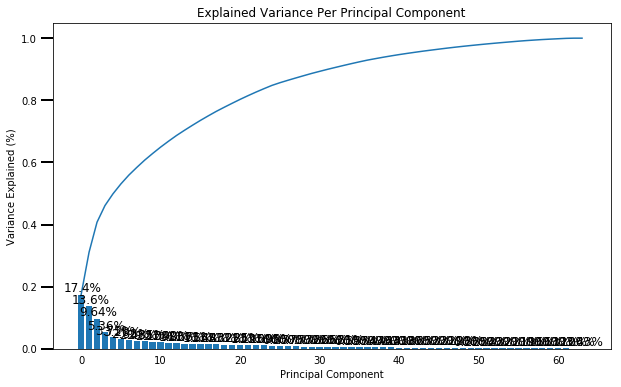

In [87]:
scree_plot(pca)

In [88]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    
    Screencast_Example_Code
    '''
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [89]:
pca_25, X_pca_25 = do_pca(25, df_no_missing)

### Discussion 2.2: Perform Dimensionality Reduction
- Captured 80% of the variance with 25 principal components
- I retaining to the next step 25 features

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [90]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_results(pca, component, full_dataset=df_no_missing):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    
    if component <= len(pca.components_):
        
        # Dimension indexing
        dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

        # PCA components
        components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
        components.index = dimensions

        # PCA explained variance
        ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
        variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
        variance_ratios.index = dimensions

        # Return a concatenated DataFrame
        df = pd.concat([variance_ratios, components], axis = 1)
        df_dimension = df.loc[f"Dimension {component}"].sort_values(ascending=False)
        return df_dimension, df
    else: 
        print('That is not the right input.')
    

In [91]:
df_25_1, df_total = pca_results(pca_25, 1)
df_25_1.head()

PLZ8_ANTG3                0.2137
PLZ8_ANTG4                0.2076
CAMEO_INTL_2015_WEALTH    0.1972
HH_EINKOMMEN_SCORE        0.1951
ORTSGR_KLS9               0.1842
Name: Dimension 1, dtype: float64

In [92]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
df_25_2, df_total = pca_results(pca_25, 2)
df_25_2.head()

ALTERSKATEGORIE_GROB    0.2452
SEMIO_ERL               0.2243
FINANZ_VORSORGER        0.2138
SEMIO_LUST              0.1691
RETOURTYP_BK_S          0.1611
Name: Dimension 2, dtype: float64

In [93]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
df_25_3, df_total = pca_results(pca_25, 3)
df_25_3.head()

SEMIO_VERT           0.3480
SEMIO_SOZ            0.2636
SEMIO_FAM            0.2514
SEMIO_KULT           0.2315
FINANZ_MINIMALIST    0.1567
Name: Dimension 3, dtype: float64

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Dimension 1 - Indicates a region correlation with family houses, standard of living and size of community.
- 8.4 PLZ8_ANTG3 - Number of 6-10 family houses in the PLZ8 region
- 8.5 PLZ8_ANTG4 - Number of 10+ family houses in the PLZ8 region
- 4.3 CAMEO_INTL_2015_WEALTH - German CAMEO: Wealth / Life Stage Typology, mapped to international code  
- 2.4 HH_EINKOMMEN_SCORE - Estimated household net income
- 9.2 ORTSGR_KLS9 - Size of community  

Dimension 2 - Correlation by individual and standard of living.
- 1.2 ALTERSKATEGORIE_GROB - Estimated age based on given name analysis
- 1.20 SEMIO_ERL - Personality typology, for each dimension:
- 1.5 FINANZ_VORSORGER - Financial typology, for each dimension:
- 1.20 SEMIO_LUST - Personality typology, for each dimension:
- 1.19 RETOURTYP_BK_S - Return type

Dimension 3 - It presents a high Correlation, but presents features with similar information. They are linked to cost of living.
- 1.20 SEMIO_VERT - Personality typology, for each dimension:
- 1.20 SEMIO_SOZ            
- 1.20 SEMIO_FAM            
- 1.20 SEMIO_KULT           
- 1.5 FINANZ_MINIMALIST - Financial typology, for each dimension:    

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [94]:
# Over a number of different cluster counts...
    ## run k-means clustering on the data and...
    ## compute the average within-cluster distances.
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

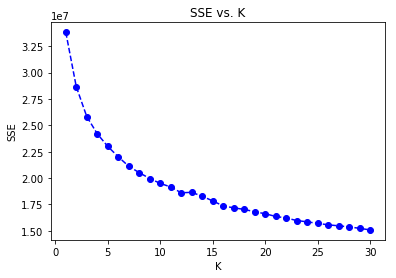

In [96]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []
centers = list(range(1,31))

for center in centers:
    scores.append(get_kmeans_score(X_pca_25, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [97]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
def fit_kmeans(data, centers):
    '''
    INPUT:
        data = the dataset you would like to fit kmeans to (dataframe)
        centers = the number of centroids (int)
    OUTPUT:
        labels - the labels for each datapoint to which group it belongs (nparray)
    
    '''
    kmeans = KMeans(centers)
    model = kmeans.fit(data)
    labels = kmeans.predict(data)
    return labels, model

In [98]:
value_for_k = 10
labels, azdias_model = fit_kmeans(X_pca_25, value_for_k)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I decided on 10 cluster because, although there is not a sharp elbow, the number ten is the region where the curve begins a less accented step.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [99]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")

In [100]:
customers.shape

(191652, 85)

In [101]:
# Apply preprocessing, feature transformation, 
customers_clean = clean_data(customers)
customers_no_missing = customers_clean.dropna()

In [102]:
customers_clean.shape

(144967, 64)

In [103]:
# and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
X_customers_scaler = StandardScaler().fit(customers_no_missing)
X_customers_clean = X_customers_scaler.transform(customers_no_missing)

In [104]:
pca_customers_clean = pca_25.transform(X_customers_clean)

In [105]:
pca_customers_clean

array([[-3.70537851, -0.63786355,  3.09423275, ...,  0.38769517,
        -0.29097614,  0.33241429],
       [ 0.38171718,  4.07459361, -2.27101101, ..., -1.11417101,
         0.43441962,  1.14191199],
       [ 4.76335895, -2.41618385, -0.71164326, ..., -0.47565774,
         1.41889979,  0.92977261],
       ..., 
       [-2.50060647,  1.43936961,  1.1152906 , ...,  0.10672819,
        -1.52949205, -0.58390763],
       [ 1.33316093,  1.65012317, -3.80926637, ..., -0.88241216,
        -0.47129071,  0.20507206],
       [-0.67658836, -4.92273526,  0.86186405, ...,  1.02029827,
        -0.36101035, -1.0252222 ]])

In [106]:
#K-means
customers_labels = azdias_model.predict(pca_customers_clean)

In [107]:
customers_labels

array([5, 4, 1, ..., 5, 4, 9], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'general population')

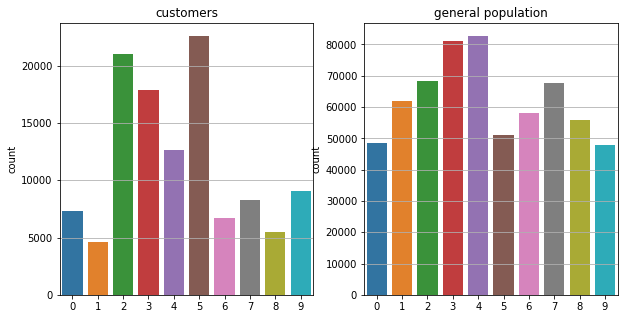

In [108]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

plt.figure(figsize=(10,5))
#figure.subplots_adjust(hspace = 2, wspace=.3)

plt.subplot(121)
plt.grid(b=True)
sns.countplot(customers_labels)
plt.title("customers")

plt.subplot(122)
plt.grid(b=True)
sns.countplot(labels)
plt.title("general population")

In [109]:
def reverse_data(pca, center_n, model = azdias_model, columns = customers_clean.columns):
    center_data = pca.inverse_transform(model.cluster_centers_[center_n]) 
    pca_inverse = X_customers_scaler.inverse_transform(center_data)
    df = pd.Series(data = pca_inverse, index = columns )
    return df  

In [118]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
overrepresented = [5,2,3,4]
center_df = reverse_data(pca_25, 5)
print(f"Head: \n {center_df.head()} \n \n Tail: \n  {center_df.tail()}")

Head: 
 ALTERSKATEGORIE_GROB    3.865834
ANREDE_KZ               0.909588
FINANZ_MINIMALIST       5.572572
FINANZ_SPARER           0.820977
FINANZ_VORSORGER        5.041368
dtype: float64 
 
 Tail: 
  RELAT_AB                          2.737008
PRAEGENDE_JUGENDJAHRE_DECADE      2.163050
PRAEGENDE_JUGENDJAHRE_MOVEMENT    1.409847
CAMEO_INTL_2015_WEALTH            1.417689
CAMEO_INTL_2015_LIFESTAGE         4.046323
dtype: float64


In [119]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrepresented = [1,8,6,0]
center_df = reverse_data(pca_25, 1)
print(f"Head: \n {center_df.head()} \n \n Tail: \n  {center_df.tail()}")

Head: 
 ALTERSKATEGORIE_GROB    2.689893
ANREDE_KZ               1.805590
FINANZ_MINIMALIST       2.878151
FINANZ_SPARER           2.234728
FINANZ_VORSORGER        3.860831
dtype: float64 
 
 Tail: 
  RELAT_AB                          3.585719
PRAEGENDE_JUGENDJAHRE_DECADE      4.029377
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.301364
CAMEO_INTL_2015_WEALTH            3.612371
CAMEO_INTL_2015_LIFESTAGE         2.688525
dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data
The Clusters 5, 2, 3, 4 are overrepresented. The cluster 5 has characteristicas that represent a person 
between the ages of 46 and 60 years old and form an older couple.

The clusters 1, 8, 6, 0 are underrepresented. The cluster 1 has features tha represent a person between the ages 30 and 45 years old with Comfortable Households and form an young Couples With Children.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.